In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from sklearn import linear_model
import os
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
# http://statsmodels.sourceforge.net/0.6.0/generated/statsmodels.tsa.arima_model.ARIMA.html
# http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [42]:
NZ = pd.read_csv("pounds_nz.csv")

In [3]:
NZ.head()

,date,xrate
0,1991.00,2.9243
1,1991.25,2.9422
2,1991.50,3.1719
3,1991.75,3.2542
4,1992.00,3.3479


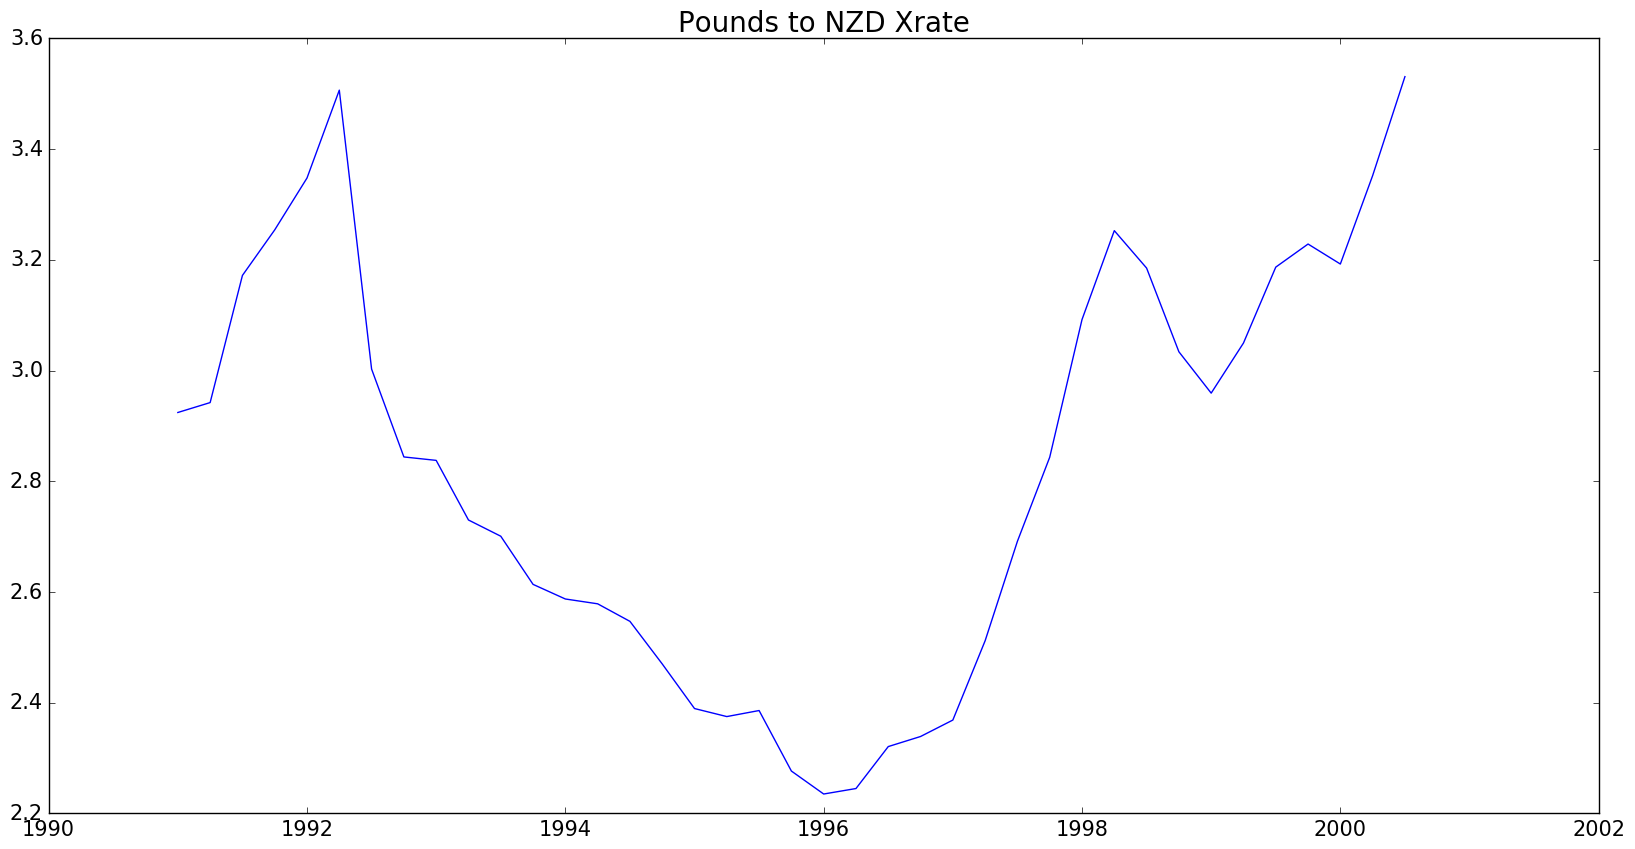

In [4]:
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(111)

## the data
x1 = NZ['date']
y1 = NZ['xrate']

ax1.plot(x1,y1,color='blue')
ax1.tick_params(labelsize=15)
ax1.set_title("Pounds to NZD Xrate", fontsize=20)

plt.show()

In [5]:
len(NZ)

39

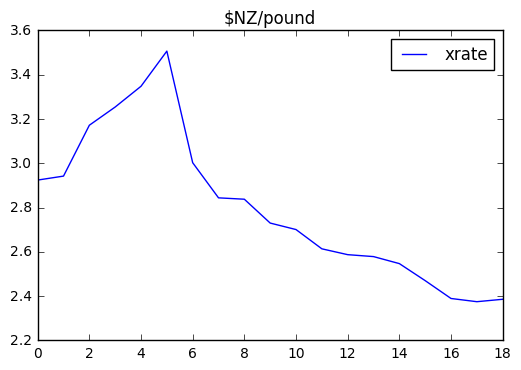

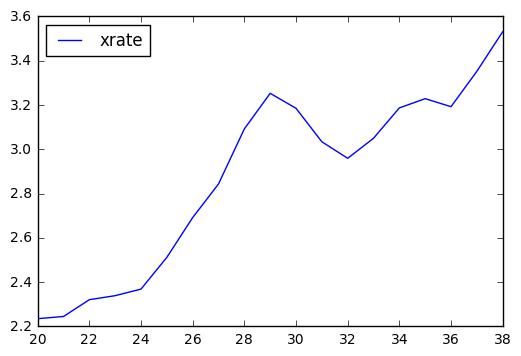

In [27]:
NZ.iloc[0:19].plot(y="xrate").set_title('$NZ/pound')
NZ.iloc[20:39].plot(y="xrate")

In [28]:
## ARIMA: Auto-Regressive Integrated Moving Averages. 
# The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. 
# The predictors depend on the parameters (p,d,q) of the ARIMA model:

# Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. 
# For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
#
# Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. 
# For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference 
# between the moving average at ith instant and actual value.
#
# Number of Differences (d): These are the number of nonseasonal differences, i.e. 
# in this case we took the first order difference. So either we can pass that variable and 
# put d=0 or pass the original variable and put d=1. Both will generate same results.

In [43]:
#make sure you can read dates as dates
NZ['month'] = NZ['date'] - np.fix(NZ['date'])
#convert decimal to month number
NZ['month'] = (NZ['month'] * 12)+1
NZ['date'] = np.fix(NZ['date'])
# round the month number, make into string, remove ".0"
NZ['month'] = NZ.apply(lambda row: str(round(row['month'], 0)).replace('.0', ''), axis=1)
# add leading zero to single digit month numbers
NZ['month'] = NZ.apply(lambda row: '0' + row['month'] if len(row['month'])==1 else row['month'], axis=1)
# add column fulldate - concatonate year and month
NZ['fulldate'] = NZ.apply(lambda row: str(round(row['date'], 0)).replace('.0', '') + '-' + row['month'], axis=1)

In [46]:
#convert fulldate string to date - Pandas http://chrisalbon.com/python/pandas_time_series_basics.html
NZ['fulldate'] = pd.to_datetime(NZ['fulldate'])
NZ.index = NZ['fulldate']
del NZ['date']
del NZ['month']
del NZ['fulldate']

In [47]:
NZ.head()

,xrate
fulldate,
1991-01-01,2.9243
1991-04-01,2.9422
1991-07-01,3.1719
1991-10-01,3.2542
1992-01-01,3.3479


/Users/nmolivo/anaconda/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


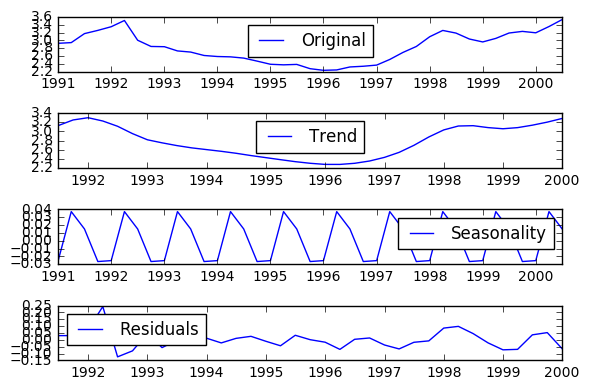

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(NZ)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(NZ, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [50]:
ts_log_diff = NZ - NZ.shift()

In [51]:
#see if electricity and exchange rate have correlative patterns
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

LinAlgError: SVD did not converge